# Fifth Model (ResNet, Three Residual Blocks)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#### Prepare for Dataset

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


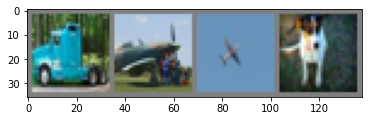

truck plane plane   dog


In [3]:
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images.
dataiter = iter(trainloader)
images, labels = next(dataiter)
# Show images.
imshow(torchvision.utils.make_grid(images))
# Print labels.
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

#### Choose a Device

In [4]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


#### Network Definition

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1      = nn.Conv2d(3, 16,(3,3), stride=1, padding=1)  
        
        self.conv2      = nn.Conv2d(16,16,(3,3), stride=1, padding=1)
        self.conv3      = nn.Conv2d(16,16,(3,3), stride=1, padding=1)
        
        self.conv4      = nn.Conv2d(16,32,(3,3), stride=2, padding=1)
        self.conv5      = nn.Conv2d(32,32,(3,3), stride=1, padding=1)
        self.downsample1= nn.Conv2d(16,32,(1,1), stride=2)
        
        self.conv6      = nn.Conv2d(32,64,(3,3), stride=2, padding=1)
        self.conv7      = nn.Conv2d(64,64,(3,3), stride=1, padding=1)
        self.downsample2= nn.Conv2d(32,64,(1,1), stride=2)
        
        self.fc1        = nn.Linear(256, 512)
        self.fc2        = nn.Linear(512, 10)
        
    def forward(self, x):
        x  =  F.relu(self.conv1(x))                       #16x32x32        
        x_ =  x
        
        #First Residual Block
        x  =  F.relu(self.conv2(x))                       #16x32x32     
        x  =  self.conv3(x)                               #16x32x32
        x +=  x_
        x  =  F.relu(x)                                   #16x32x32
        x_ =  x
        
        #Second Residual Block
        x  =  F.relu(self.conv4(x))                       #32x16x16      
        x  =  self.conv5(x)                               #32x16x16       
        x +=  self.downsample1(x_)                         
        x  =  F.relu(x)                                   #32x16x16 
        x_ =  x
        
        #Third Residual Block
        x  =  F.relu(self.conv6(x))                       #64x8x8      
        x  =  self.conv7(x)                               #64x8x8       
        x +=  self.downsample2(x_)                         
        x  =  F.relu(x)                                   #64x8x8
                
        x  =  F.avg_pool2d(x,(4,4))                       #64x2x2                
        
        x  =  torch.flatten(x, 1)
        x  =  F.relu(self.fc1(x))                          #512
             
        x  =  self.fc2(x)                                  #10
        return x

net = Net()    
net.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downsample1): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2))
  (conv6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downsample2): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
  (fc1): Linear(in_features=256, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [6]:
num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Number of trainable parameters: ", num_params)

Number of trainable parameters:  213770


#### Optimizer and Loss Function

In [7]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# We use stochastic gradient descent (SGD) as optimizer.
opt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

#### Training Procedure

In [8]:
avg_losses = []   
epochs = 10       
print_freq = 10000  

for epoch in range(epochs):  
    running_loss = 0.0       
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:  9999] avg mini-batch loss: 1.931
[epoch: 1, i:  9999] avg mini-batch loss: 1.455
[epoch: 2, i:  9999] avg mini-batch loss: 1.206
[epoch: 3, i:  9999] avg mini-batch loss: 1.022
[epoch: 4, i:  9999] avg mini-batch loss: 0.883
[epoch: 5, i:  9999] avg mini-batch loss: 0.781
[epoch: 6, i:  9999] avg mini-batch loss: 0.696
[epoch: 7, i:  9999] avg mini-batch loss: 0.631
[epoch: 8, i:  9999] avg mini-batch loss: 0.576
[epoch: 9, i:  9999] avg mini-batch loss: 0.528
Finished Training.


#### Training Loss Curve

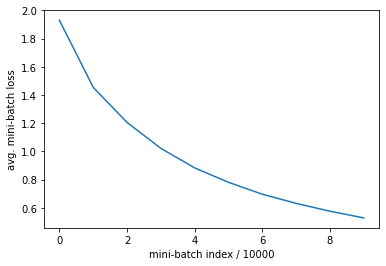

In [9]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

#### Evaluate on Test Dataset

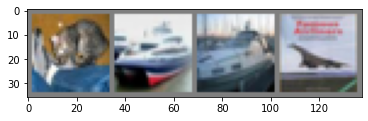

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane


In [10]:
# Check several images.
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [11]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 76 %


In [12]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 80 %
Accuracy of   car : 83 %
Accuracy of  bird : 69 %
Accuracy of   cat : 61 %
Accuracy of  deer : 73 %
Accuracy of   dog : 56 %
Accuracy of  frog : 81 %
Accuracy of horse : 83 %
Accuracy of  ship : 88 %
Accuracy of truck : 85 %


Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/conda/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 667, in start
    self.io_loop.start()
  File "/opt/conda/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/opt/conda/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
    self._run_once()
  File "/opt/conda/lib/python3.9/asyncio/base_events.py", line 1854, in _run_once
    event_list = self._selector.select(timeout)
  File "/opt/cond